In [17]:
pip install duckduckgo_search


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
from langchain.tools import tool
from langchain_groq import ChatGroq
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

In [19]:

llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)
search=DuckDuckGoSearchRun()

In [20]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

In [21]:
tools=[multiply, add, divide, search]
llm_with_tools=llm.bind_tools(tools)

In [22]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

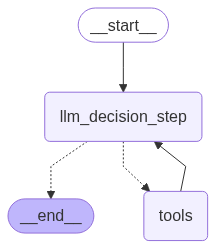

In [23]:
builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_decision_step")
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
builder.add_edge("tools","llm_decision_step")
react_graph=builder.compile()
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [25]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='18d557e8-ed4d-4560-94e9-19b6070118dd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dh97jmeja', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 329, 'prompt_tokens': 423, 'total_tokens': 752, 'completion_time': 1.196363636, 'prompt_time': 0.027150323, 'queue_time': 0.201933765, 'total_time': 1.223513959}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1bbf4d3b-c9b7-45a7-89a8-4f37f770bfff-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age'}, 'id': 'dh97jmeja', 'type': 'tool_call'}], usage_metadata={'input_tokens': 423, 'output_tokens': 329, 'total_tokens': 752}),
  ToolMessage(content="Narendra Mo

In [26]:
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]
response=react_graph.invoke({"messages":message})
response

{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='c479ef08-7726-4fcc-ba61-93a8afb4c548'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'z7r6n8q1f', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 376, 'prompt_tokens': 427, 'total_tokens': 803, 'completion_time': 1.439564763, 'prompt_time': 0.034836682, 'queue_time': 0.201520868, 'total_time': 1.474401445}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f7916cf2-2c6c-4565-81e4-f17fee3a4d6f-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'z7r6n8q1f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 427, 'output_tokens': 376, 'total_tokens': 803}),

TypeError: 'AIMessage' object is not subscriptable